In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# User Behavior in FOREX Trading

### Introduction

The goal of this project is to explore a dataset with clients from this year representing a specific unregulated FOREX trading brand that our company owns. Based on the conducted analysis we would draw conclusions and provide recommendations on the country blend currently in place. Our findings might change the brand's leads traffic thus influencing the company's sales and marketing strategies.

We are going to also look for interesting patterns and correlations within the various trading parameters and check whether our findings could be observed also in regulated brands. A problem that the business is nowadays seriously interested in is whether clients are logging in to our trading platforms only because of our agents calling them or users' self-initiative is becoming the main driving force. Ideally, our analysis would translate into meaningful business information that could be used by the top management of the company for taking better informed decisions.

Finally, we are going to model our data using logistic regression. Our goal would be to try predicting the current activity status of a user based on the historical data we have accumulated for him. In case the model shows high accuracy, we could use it within the future as a stepping stone for developing a system that would allow us to foretell the activity potential of all new users based, for example, only on their activity within their first week with us. Such a model would be highly valuable for a company like ours. 

### 1. Cleaning up our dataset
   We need a tidy dataset and here we are going to prepare it. In general, we are going to rename columns, add some new            ones, drop some that we no longer need, replace value names and format certain parameters.

In [4]:
# Reading our data, getting rid of our first two rows and making the 'User Id' column our index column
mexico_data = pd.read_csv("~/Mexico_leads_data.csv", header = 2, index_col = "User Id")

In [5]:
# Giving one of our columns a more user-friendly name
mexico_data["Agent Desk Name"] = mexico_data["First Ret Assign Desk Name"]

In [6]:
# Also we want to display the full activity status name of the users and give the column a better name
mexico_data["Current Activity Status"] = mexico_data["Client Activity Status Type Name"].replace({'D': 'Dormant', 'C': 'Churning', 'A': 'Active'})

In [7]:
# Let's add an interesting parameter that is very important in non-automated FOREX trading companies - the % of answered calls per user
mexico_data["% Answered Calls"] = np.round(mexico_data["# Answered Calls"] / mexico_data["# Total Calls"] * 100, 2)

In [8]:
# We can see that the column representing the net time spent on the phone by users is in seconds - let's convert it to minutes, round the number up and give our new column a name
mexico_data["Net Call Time in Min"] = np.round(mexico_data["SumBillsec"] / 60, 2)

In [9]:
# Finally, we are getting rid of the columns we no longer need, either because we have the information elsewhere or because the column does not give us valuable information
mexico_data = mexico_data.drop(['Client Activity Status Type Name', 'First Ret Assign Desk Name', 'Lead Office' , 'SumBillsec'], axis = 1)

In [10]:
# We can see that our dataset looks proper now
mexico_data.head()

,First RTN assignment,First Position Date,First Unprotected Position Date,First Liquidation Date,First Deposit Date,First Withdrawal Date,First Login Date,# Withdrawal Transactions,# Deposit Transactions,Agent Team Name,...,# Answered Calls,# Logins,# Total Calls,# Liquidations,# Protected positions,# Unprotected Positions,Agent Desk Name,Current Activity Status,% Answered Calls,Net Call Time in Min
User Id,,,,,,,,,,,,,,,,,,,,,
4330088,9/1/2020 17:08,20/01/2020,28/01/2020,28/02/2020,7/1/2020,1/1/1900,15/03/2017,0,1,Team A,...,45.0,141,226.0,1.0,5.0,33,Desk C,Dormant,19.91,321.25
4396585,22/02/2020 17:48:38,5/3/2020,24/03/2020,12/3/2020,21/02/2020,1/1/1900,8/4/2017,0,1,Team B,...,87.0,119,233.0,2.0,5.0,37,Desk F,Dormant,37.34,1409.87
4784070,24/01/2020 23:31:41,20/02/2020,27/02/2020,16/03/2020,23/01/2020,1/1/1900,14/07/2017,0,2,Team B,...,29.0,243,109.0,1.0,5.0,55,Desk C,Dormant,26.61,76.68
4799142,15/01/2020 15:10:13,17/01/2020,22/01/2020,12/2/2020,14/01/2020,3/2/2020,20/07/2017,1,2,Team A,...,72.0,659,183.0,2.0,5.0,135,Desk F,Dormant,39.34,730.65
4959701,10/2/2020 16:01,10/2/2020,12/2/2020,27/02/2020,8/2/2020,1/1/1900,13/09/2017,0,4,Team B,...,103.0,853,281.0,3.0,5.0,311,Desk A,Dormant,36.65,800.93


### 2. Inspecting the data
   We can see that many of our columns have the wrong data types and we also have a certain amount of empty values at some        places. Here we are going to fix that.

In [11]:
# Converting our date columns to datetime format
mexico_data.iloc[:, 0:7] = mexico_data.iloc[:, 0:7].apply(pd.to_datetime, errors = 'coerce')

In [12]:
# Removing the commas from certain columns and converting them to float type
mexico_data['# Total Positions'] = mexico_data['# Total Positions'].str.replace(',', '').astype(float)
mexico_data['# Unprotected Positions'] = mexico_data['# Unprotected Positions'].str.replace(',', '').astype(float)

In [13]:
# Due to the nature of the data within the columns containing null values, we can simply add 0 to fill them up
mexico_data = mexico_data.fillna(0)

In [14]:
# Now our dataset is ready for analysis
mexico_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 4330088 to 8070529
Data columns (total 23 columns):
First RTN assignment               7060 non-null datetime64[ns]
First Position Date                7060 non-null datetime64[ns]
First Unprotected Position Date    7060 non-null datetime64[ns]
First Liquidation Date             7060 non-null datetime64[ns]
First Deposit Date                 7060 non-null datetime64[ns]
First Withdrawal Date              7060 non-null datetime64[ns]
First Login Date                   7060 non-null datetime64[ns]
# Withdrawal Transactions          7060 non-null int64
# Deposit Transactions             7060 non-null int64
Agent Team Name                    7060 non-null object
Agent Group Name                   7060 non-null object
# Total Positions                  7060 non-null float64
Lead Country                       7060 non-null object
# Answered Calls                   7060 non-null float64
# Logins                           7060 non-

### 3. Exploring the data
   We want to check for certain trends and statistics strictly related to the country blend. Our goal is to advise whether the    current users' traffic distribution is the most optimal one or changes need to be implemented, while at the same time        stepping on research conducted in the past. 

In [15]:
# First we can check how this year's users are distributed
mexico_data.groupby("Lead Country")["First RTN assignment"].count()

Lead Country
Argentina               20
Brazil                   1
Chile                  622
Colombia              1479
Costa Rica             213
Dominican Republic      22
Ecuador                 38
El Salvador            847
Guatemala                1
Mexico                1635
Paraguay                 1
Peru                  1956
Uruguay                221
Venezuela                4
Name: First RTN assignment, dtype: int64

We are seeing countries like Brazil and Paraguay that are not supposed to be part of the FOREX trading brand that we are analyzing and have gotten here by mistake, or  countries like Guatemala and Venezuela whose users' numbers are too low for making general conclusions. Let's remove them.

In [16]:
# Defining a function for listing countries that are not of interest in view of the current analysis 
def weak_traffic_countries(mexico_data, cutoff):
    """
    Returns a list of countries where the amount of users is below the cut-off threshold
    """
    countries = None
    unnecessary_countries = None
    countries = mexico_data.groupby("Lead Country")["First RTN assignment"].count()
    unnecessary_countries = list(countries[countries < cutoff].index)
    return unnecessary_countries

In [17]:
# Removing the rows with users representing the countries we are not currently interested in. We are setting the cut-off threshold at 5
countries_of_interest_data = mexico_data.drop(mexico_data[mexico_data["Lead Country"].isin(weak_traffic_countries(mexico_data, 5))].index)

Now that we have our data covering only countries of interest, we can start plotting it, while focusing on the main performance indicators that we track in the retention part of the FOREX business. 

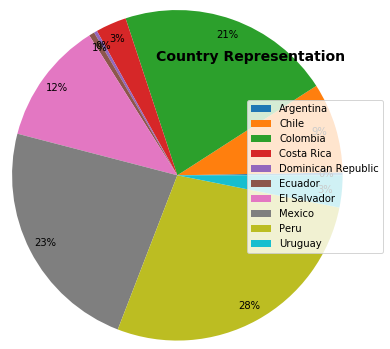

In [62]:
# Plotting a pie chart with the country distribution
countries_of_interest = countries_of_interest_data.groupby("Lead Country")["First RTN assignment"].count()
plt.gca().axis("equal")
pie = plt.pie(countries_of_interest, startangle=0, autopct='%1.0f%%', pctdistance=0.9, radius=1.9)
labels = countries_of_interest.index.unique()
plt.title("Country Representation", weight='bold', loc = "right", size=14)
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.show()

It is clear that most of our clients are coming from Mexico, Peru, Colombia and El Salvador, which has been the case for quite some time. We are interested in investing more in Ecuador so we can check whether increasing the presence of users from this country within the country blend would be justified or not. Key performance indicators like average number of deposits and positions, as well as levels of user responsiveness and trading addiction are going to be analyzed.  

In [63]:
# Creating a function for plotting a bar chart accepting a variable, title and y label name as parameters
def plotting_bar_per_country(statistic_variable, title, ylabel):
    """
    Plots a bar chart using the provided parameters
    """
    plt.figure(figsize = [9,6])
    plt.bar(np.arange(len(statistic_variable)), statistic_variable.values, align='center', alpha=0.5)
    plt.xticks(np.arange(len(statistic_variable)), statistic_variable.index, rotation = 'vertical')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

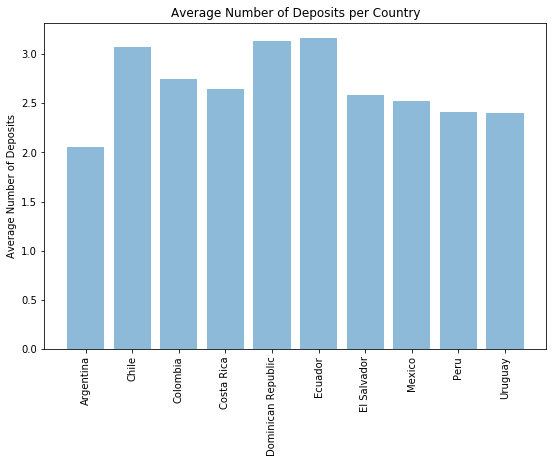

In [64]:
# Checking the average number of deposits per country
average_number_of_deposits = countries_of_interest_data.groupby("Lead Country")["# Deposit Transactions"].mean()
plotting_bar_per_country(average_number_of_deposits,
                         'Average Number of Deposits per Country',
                         'Average Number of Deposits')

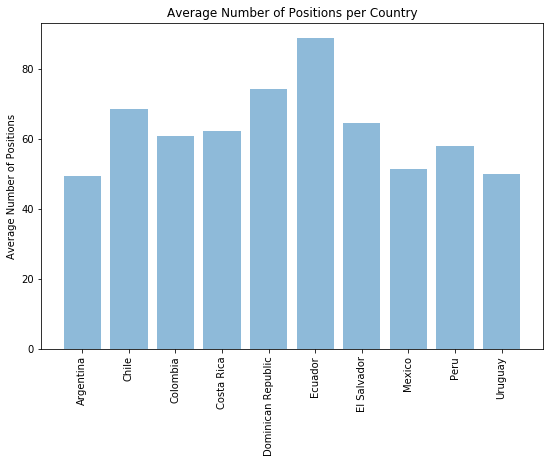

In [65]:
# Checking the average number of positions per country
average_number_of_positions = countries_of_interest_data.groupby("Lead Country")["# Total Positions"].mean()
plotting_bar_per_country(average_number_of_positions,
                         'Average Number of Positions per Country',
                         'Average Number of Positions')

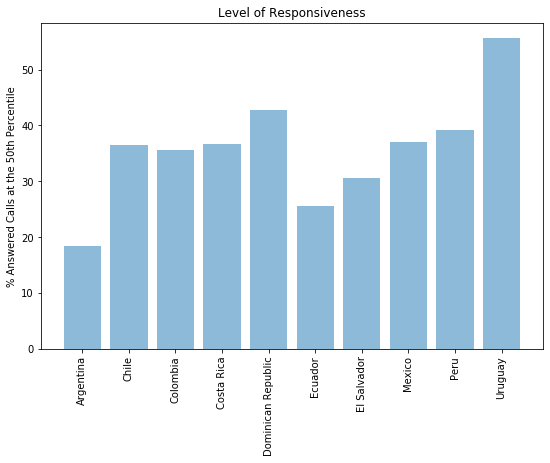

In [66]:
# Observing the level of responsiveness per country
level_of_responsiveness = countries_of_interest_data.groupby("Lead Country")["% Answered Calls"].quantile(0.5)
plotting_bar_per_country(level_of_responsiveness,
                         'Level of Responsiveness',
                         '% Answered Calls at the 50th Percentile')

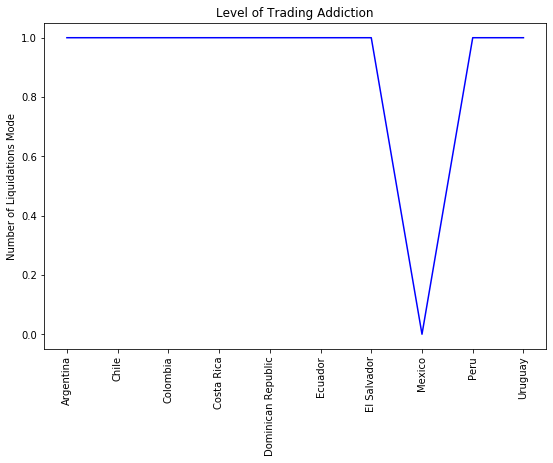

In [67]:
# Plotting the mode of the number of liquidations per country
level_of_trading_addiction = countries_of_interest_data.groupby("Lead Country")["# Liquidations"].agg(pd.Series.mode)
plt.figure(figsize = [9,6])
plt.plot(level_of_trading_addiction, color='Blue')
plt.ylabel('Number of Liquidations Mode')
plt.xticks(np.arange(len(level_of_trading_addiction)), level_of_trading_addiction.index, rotation = 'vertical')
plt.title('Level of Trading Addiction')
plt.show()

Based on the data that we got it could be concluded that the traffic from Ecuador is worth increasing - users there have by far the largest average number of positions and also the highest average amount of deposit transactions. In addition, they also look responsive on the phone - 50% of the users there have answered more than 25% of their calls. Dominican Republic results look good as well but there we have to take into consideration the actual costs related to attracting clients - they are quite high so let's just leave it for now. Another interesting aspect that we are noting here is that Uruguay users have very high level of phone responsiveness but deposit and trading parameters are not good enough, which means that the agents are not doing a good job despite potential being clearly there.

On the last chart we can see that there is no difference between the countries when it comes to number of liquidations - I am speaking from experience when I say that in general most users stop trading after their first liquidation either because they get afraid of the possibility of losing more money, or because of lack of trust towards the dealings of the trading company.

When we take into consideration also other FOREX trading parameters that are not included in our dataset such as deposit amounts, rollover fees, commissions and spreads, we would see that usually the big clients are coming from Mexico, Peru and Colombia. Those countries have the highest lifetime value and trading volumes therefore for us it is reasonable to continue investing in those markets. As a conclusion we could also say that the flow from Ecuador should be increased but slowly and trading parameters there should be carefully observed on a monthly basis. Chile's deposit and trading results are also improving when compared to last year so the country's presence within the country blend should be increased as well. We are going to take that with the marketing and sales departments. 


### 4. Looking for correlations in the retention parameters
   After we researched how the different groups of users perform based on their country, we can now check for interesting          retention parameter correlations.

In [18]:
# Checking all correlations on all variables using the Pearson standard correlation coefficient
countries_of_interest_data.corr()

,# Withdrawal Transactions,# Deposit Transactions,# Total Positions,# Answered Calls,# Logins,# Total Calls,# Liquidations,# Protected positions,# Unprotected Positions,% Answered Calls,Net Call Time in Min
# Withdrawal Transactions,1.000000,0.258760,0.187878,0.203831,0.207712,0.109052,0.007116,0.064387,0.187077,0.029455,0.190543
# Deposit Transactions,0.258760,1.000000,0.540663,0.528255,0.450631,0.283742,0.275646,0.138787,0.539719,0.139613,0.497205
# Total Positions,0.187878,0.540663,1.000000,0.496732,0.642622,0.269640,0.375548,0.210918,0.999592,0.130922,0.463614
# Answered Calls,0.203831,0.528255,0.496732,1.000000,0.503848,0.665485,0.390524,0.150497,0.495193,0.164581,0.777900
# Logins,0.207712,0.450631,0.642622,0.503848,1.000000,0.279415,0.387089,0.166263,0.641461,0.126918,0.431165
# Total Calls,0.109052,0.283742,0.269640,0.665485,0.279415,1.000000,0.274721,0.069924,0.269148,-0.410362,0.441391
# Liquidations,0.007116,0.275646,0.375548,0.390524,0.387089,0.274721,1.000000,0.111801,0.374442,0.001218,0.315778
# Protected positions,0.064387,0.138787,0.210918,0.150497,0.166263,0.069924,0.111801,1.000000,0.182906,0.061994,0.173245
# Unprotected Positions,0.187077,0.539719,0.999592,0.495193,0.641461,0.269148,0.374442,0.182906,1.000000,0.129863,0.461219
% Answered Calls,0.029455,0.139613,0.130922,0.164581,0.126918,-0.410362,0.001218,0.061994,0.129863,1.000000,0.201534


We can see some interesting things here that are going to help us with understanding the nature of the business better. For example, the number of deposit transactions correlates strongly with the number of positions and the number of answered calls - logically, a guy who is more responsive on the phone is more interested in depositing and more willing to trade. Another thing worth mentioning is the connection between the number of unprotected positions, which is considered real trading cause losses are not being covered by the broker, and the amount spent on the phone. It looks like a client needs more attention and "nurturing" on behalf of the agent so that he would risk and start trading for real. 

A problem that the business is interested in is whether clients are logging in because of personal interest or because our call agents are sparking their interest and pushing them to do so. We can perform hypothesis testing on how the number of answered calls of users with number of logins below the parameter's mean correlates to that number for users with logins above that threshold.  

In [19]:
# Creating a new column flagging users whose number of logins is higher than the average
countries_of_interest_data.loc[countries_of_interest_data["# Logins"] >= countries_of_interest_data["# Logins"].mean(), "# Logins equal to or above column mean"] = 1
countries_of_interest_data.loc[countries_of_interest_data["# Logins"] < countries_of_interest_data["# Logins"].mean(), "# Logins equal to or above column mean"] = 0

In [20]:
# Grouping the data and storing the two groups within their own variables
logins_grouping_per_answered_calls = countries_of_interest_data.groupby("# Logins equal to or above column mean")["# Answered Calls"]
group_below_threshold = logins_grouping_per_answered_calls.get_group(0)
group_above_threshold = logins_grouping_per_answered_calls.get_group(1)

To perform the hypothesis test, we need a pair of hypotheses. In this case our null hypothesis is that there is no relationship between the number of logins and the number of answered calls and the results are not significant in terms of supporting the idea being investigated. The alternative hypothesis says the opposite - one variable does affect the other one making it dependent. We assume that the null hypothesis is true and we proceed to performing a t-test on our two variables with a threshold value of 𝑝 set at 1%.

In [21]:
# Performing a t-test on our two previously defined variables
test_result = ttest_ind(group_below_threshold, group_above_threshold , equal_var = False)
print(test_result.pvalue)
if test_result.pvalue <= 0.01:
    print("The differences in the number of phone calls are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

7.232392483789353e-221
The differences in the number of phone calls are significant. Reject H0.


We can conclude that the distributions of answered calls are significantly different at the 1% level. It should be noted that the data we are observing covers users from unregulated brands, which means that the trading agents have more freedom, while talking to clients on the phone because the business is not being regulated by any of the commodities and futures trading commissions. And that on the other hand suggest for more calls and respectively more answered calls. However, that is not the case with our regulated brands where regulations are very strict so we can check if we are going to get similar results there.

In [22]:
# Getting a dataset of similar size covering users from regulated brands for the same time period 
regulated_leads_data = pd.read_csv("~/Regulated_leads_data.csv", header = 2, index_col = "User Id")

In [23]:
# Filling up the null values
regulated_leads_data = regulated_leads_data.fillna(0)

In [24]:
# Creating a new column flagging users whose number of logins is higher than the average
regulated_leads_data.loc[regulated_leads_data["# Logins"] >= regulated_leads_data["# Logins"].mean(), "# Regulated logins equal to or above column mean"] = 1
regulated_leads_data.loc[regulated_leads_data["# Logins"] < regulated_leads_data["# Logins"].mean(), "# Regulated logins equal to or above column mean"] = 0

In [25]:
# Grouping the data and storing the two groups within their own variables as we did before
logins_grouping_per_answered_calls_for_regulated = regulated_leads_data.groupby("# Regulated logins equal to or above column mean")["# Answered Calls"]
group_below_threshold_regulated = logins_grouping_per_answered_calls_for_regulated.get_group(0)
group_above_threshold_regulated = logins_grouping_per_answered_calls_for_regulated.get_group(1)

In [26]:
# Performing a t-test on our two previously defined variables
test_result_regulated = ttest_ind(group_below_threshold_regulated, group_above_threshold_regulated , equal_var = False)
print(test_result_regulated.pvalue)
if test_result_regulated.pvalue <= 0.01:
    print("The differences in the number of phone calls are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

5.276845972359092e-204
The differences in the number of phone calls are significant. Reject H0.


We are getting similar results for our second dataset, which means that users from regulated brands do not act much different than those trading at unregulated ones. Our overall conclusion could be that agents still need to call users in order for them to login to our platforms. Which on the other hand suggests that our business is not ready for automating the retention process and cutting all costs related to paying call agents cause user activity is still too dependent on human contact. 

### 5. Modelling the data 
   We would like to develop a classification model using logistic regression. Our target variable is going to be a key            parameter for our business - the user activity status.

In general the user activity status is being determined by whether the client has made a deposit or has opened a position within the last 35 or 60 days. His status would change from active to churning if he did not do either of those activities within the last 35 days. In case the number of inactive days reaches 60 the status changes from churning to dormant. Now, based on the data we have we would like to predict if the status of a given user is active or not by using logistic regression and performing all the accompanying steps. 

In [27]:
# Turning our lead country and activity status columns to indicator variables because scikit-learn doesn't know how to deal with text and categories
countries_of_interest_data_for_modelling = pd.get_dummies(data = countries_of_interest_data, columns=["Lead Country", "Current Activity Status"])

In [28]:
# Removing the unnecessary columns, most importantly those with the other two statuses - dormant and churning
countries_of_interest_data_for_modelling = countries_of_interest_data_for_modelling.drop(["First RTN assignment", "First Position Date", "First Unprotected Position Date", "First Liquidation Date", "First Deposit Date", "First Withdrawal Date" , "First Login Date", "Agent Team Name", "Agent Desk Name", "Agent Group Name", "Current Activity Status_Dormant", "Current Activity Status_Churning"], axis = 1)

In [29]:
# Now we are ready with the data that we are going to use for our model
countries_of_interest_data_for_modelling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7053 entries, 4330088 to 8070529
Data columns (total 23 columns):
# Withdrawal Transactions                 7053 non-null int64
# Deposit Transactions                    7053 non-null int64
# Total Positions                         7053 non-null float64
# Answered Calls                          7053 non-null float64
# Logins                                  7053 non-null int64
# Total Calls                             7053 non-null float64
# Liquidations                            7053 non-null float64
# Protected positions                     7053 non-null float64
# Unprotected Positions                   7053 non-null float64
% Answered Calls                          7053 non-null float64
Net Call Time in Min                      7053 non-null float64
# Logins equal to or above column mean    7053 non-null float64
Lead Country_Argentina                    7053 non-null uint8
Lead Country_Chile                        7053 non-null uint

In [30]:
# Making 'Current Activity Status_Active' our target variable, while all other variables will be our explanatory ones
countries_of_interest_data_features = countries_of_interest_data_for_modelling.drop("Current Activity Status_Active", axis = 1)
countries_of_interest_data_target = countries_of_interest_data_for_modelling["Current Activity Status_Active"]

In [31]:
# We can see that our target data is relatively equally distributed
countries_of_interest_data_target.value_counts(normalize = True)

1    0.556643
0    0.443357
Name: Current Activity Status_Active, dtype: float64

In [32]:
# Rescaling the values for each numeric column using a min-max normalization for algorithm stability and convergence
scaler = MinMaxScaler()
countries_of_interest_data_features_scaled = scaler.fit_transform(countries_of_interest_data_features)

In [33]:
# Splitting the data into training and test subsets using a 70-30 distribution ratio
features_train, features_test, target_train, target_test = train_test_split(
    countries_of_interest_data_features_scaled, countries_of_interest_data_target, train_size = 0.7, test_size = 0.3, random_state = 42)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

(4937, 22)
(2116, 22)
(4937,)
(2116,)


In [34]:
# Creating a logistic regression model and fitting the model using the training features and training target
model = LogisticRegression()
model.fit(features_train, target_train)

C:\Users\yasen.nestorov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# Scoring the model
score = model.score(features_test, target_test)
print(score )

0.7296786389413988


The scoring metric of our classification model is accuracy. That means that we have a 71% chance of predicting correctly whether a user is active or not when using it. Within the future we can try developing something more complicated that would allow us to evaluate the potential of all incoming clients based only on their initial activity. Why would that be so important for us? For example we would be able to assign high-potential users to our top agents, while moving lower-potential guys to rookie agents. Or we could give high-potential guys bigger bonuses or more credit because we would know that we would be able to make profit of them within the near future. In general, machine learning could open a lot of doors for our business.